In [78]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV



pokemon = pd.read_csv('./pokedex/pokemon.csv').sort_values(by=['number'])
pokemon

,generation,number,name,image,type1,type2,height,weight,catch_rate,egg_group1,...,sp_atk_min,sp_atk_max,sp_def,sp_def_min,sp_def_max,speed,speed_min,speed_max,total,is_legendary
0,1,1,Bulbasaur,https://img.pokemondb.net/sprites/bank/normal/...,Grass,Poison,0.7,6.9,45,Grass,...,121,251,65,121,251,45,85,207,318,False
23,1,2,Ivysaur,https://img.pokemondb.net/sprites/bank/normal/...,Grass,Poison,1.0,13.0,45,Grass,...,148,284,80,148,284,60,112,240,405,False
25,1,3,Venusaur,https://img.pokemondb.net/sprites/bank/normal/...,Grass,Poison,2.0,100.0,45,Grass,...,184,328,100,184,328,80,148,284,525,False
24,1,4,Charmander,https://img.pokemondb.net/sprites/bank/normal/...,Fire,NaN,0.6,8.5,45,Dragon,...,112,240,50,94,218,65,121,251,309,False
22,1,5,Charmeleon,https://img.pokemondb.net/sprites/bank/normal/...,Fire,NaN,1.1,19.0,45,Dragon,...,148,284,65,121,251,80,148,284,405,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,8,894,Regieleki,https://img.pokemondb.net/sprites/sword-shield...,Electric,NaN,1.2,145.0,3,NaN,...,184,328,50,94,218,200,364,548,580,True
184,8,895,Regidrago,https://img.pokemondb.net/sprites/sword-shield...,Dragon,NaN,2.1,200.0,3,NaN,...,184,328,50,94,218,80,148,284,580,True
183,8,896,Glastrier,https://img.pokemondb.net/sprites/sword-shield...,Ice,NaN,2.2,800.0,3,NaN,...,121,251,110,202,350,30,58,174,580,True
182,8,897,Spectrier,https://img.pokemondb.net/sprites/sword-shield...,Ghost,NaN,2.0,44.5,3,NaN,...,265,427,80,148,284,130,238,394,580,True


In [60]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898 entries, 0 to 181
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   generation    898 non-null    int64  
 1   number        898 non-null    int64  
 2   name          898 non-null    object 
 3   image         898 non-null    object 
 4   type1         898 non-null    object 
 5   type2         444 non-null    object 
 6   height        898 non-null    float64
 7   weight        898 non-null    float64
 8   catch_rate    898 non-null    int64  
 9   egg_group1    782 non-null    object 
 10  egg_group2    256 non-null    object 
 11  has_gender    898 non-null    bool   
 12  male          776 non-null    float64
 13  hp            898 non-null    int64  
 14  hp_min        898 non-null    int64  
 15  hp_max        898 non-null    int64  
 16  attack        898 non-null    int64  
 17  attack_min    898 non-null    int64  
 18  attack_max    898 non-null    

In [61]:
types = set.union(set(pokemon['type1'].value_counts().keys()), set(pokemon['type2'].value_counts().keys()))
egg_groups = set.union(set(pokemon['egg_group1'].value_counts().keys()), set(pokemon['egg_group2'].value_counts().keys()))
new_types = {k: v+1 for v, k in enumerate(types)}
new_egg_groups = {k: v+1 for v, k in enumerate(egg_groups)}
tf = { True: 1, False: 0}

data = pokemon.drop(columns=['number', 'name', 'image', 'total']) \
    .fillna(value=0) \
    .replace({"type1": new_types, "type2": new_types}) \
    .replace({"egg_group1": new_egg_groups, "egg_group2": new_egg_groups}) \
    .replace({"has_gender": tf, "is_legendary": tf})
data

,generation,type1,type2,height,weight,catch_rate,egg_group1,egg_group2,has_gender,male,...,sp_atk,sp_atk_min,sp_atk_max,sp_def,sp_def_min,sp_def_max,speed,speed_min,speed_max,is_legendary
0,1,16,13,0.7,6.9,45,11,12,1,87.5,...,65,121,251,65,121,251,45,85,207,0
23,1,16,13,1.0,13.0,45,11,12,1,87.5,...,80,148,284,80,148,284,60,112,240,0
25,1,16,13,2.0,100.0,45,11,12,1,87.5,...,100,184,328,100,184,328,80,148,284,0
24,1,11,0,0.6,8.5,45,3,12,1,87.5,...,60,112,240,50,94,218,65,121,251,0
22,1,11,0,1.1,19.0,45,3,12,1,87.5,...,80,148,284,65,121,251,80,148,284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,8,8,0,1.2,145.0,3,0,0,0,0.0,...,100,184,328,50,94,218,200,364,548,1
184,8,3,0,2.1,200.0,3,0,0,0,0.0,...,100,184,328,50,94,218,80,148,284,1
183,8,6,0,2.2,800.0,3,0,0,0,0.0,...,65,121,251,110,202,350,30,58,174,1
182,8,9,0,2.0,44.5,3,0,0,0,0.0,...,145,265,427,80,148,284,130,238,394,1


In [62]:
d = data.drop(columns=['generation', 'is_legendary'])
scaler = StandardScaler()
scaler.fit(d)
X_scale = scaler.transform(d)
scaled_data = pd.DataFrame(X_scale, columns=d.columns)
scaled_data.head()

,type1,type2,height,weight,catch_rate,egg_group1,egg_group2,has_gender,male,hp,...,defense_max,sp_atk,sp_atk_min,sp_atk_max,sp_def,sp_def_min,sp_def_max,speed,speed_min,speed_max
0,0.961974,1.491158,-0.393965,-0.475111,-0.689092,1.317721,1.961069,0.396505,1.492357,-0.917252,...,-0.773323,-0.159472,-0.159382,-0.161166,-0.181365,-0.181376,-0.183270,-0.736514,-0.736455,-0.738638
1,0.961974,1.491158,-0.150761,-0.425128,-0.689092,1.317721,1.961069,0.396505,1.492357,-0.344713,...,-0.297035,0.351492,0.351509,0.349636,0.372726,0.372693,0.370803,-0.209174,-0.209167,-0.211527
2,0.961974,1.491158,0.659918,0.287747,-0.689092,1.317721,1.961069,0.396505,1.492357,0.418671,...,0.378988,1.032778,1.032696,1.030705,1.111514,1.111453,1.109567,0.493945,0.493884,0.491287
3,0.017666,-0.795428,-0.475032,-0.462001,-0.689092,-0.847537,1.961069,0.396505,1.492357,-1.146267,...,-0.973057,-0.329794,-0.329679,-0.331434,-0.735456,-0.735446,-0.737343,-0.033394,-0.033404,-0.035824
4,0.017666,-0.795428,-0.069693,-0.375964,-0.689092,-0.847537,1.961069,0.396505,1.492357,-0.421052,...,-0.466040,0.351492,0.351509,0.349636,-0.181365,-0.181376,-0.183270,0.493945,0.493884,0.491287


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898 entries, 0 to 181
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   generation    898 non-null    int64  
 1   type1         898 non-null    int64  
 2   type2         898 non-null    int64  
 3   height        898 non-null    float64
 4   weight        898 non-null    float64
 5   catch_rate    898 non-null    int64  
 6   egg_group1    898 non-null    int64  
 7   egg_group2    898 non-null    int64  
 8   has_gender    898 non-null    int64  
 9   male          898 non-null    float64
 10  hp            898 non-null    int64  
 11  hp_min        898 non-null    int64  
 12  hp_max        898 non-null    int64  
 13  attack        898 non-null    int64  
 14  attack_min    898 non-null    int64  
 15  attack_max    898 non-null    int64  
 16  defense       898 non-null    int64  
 17  defense_min   898 non-null    int64  
 18  defense_max   898 non-null    

In [64]:
pokemon['is_legendary'].value_counts()

False    806
True      92
Name: is_legendary, dtype: int64

In [ ]:
# from sklearn.feature_selection import RFECV
# from sklearn.svm import SVR

# X = data
# y = data.is_legendary

# estimator = SVR(kernel="linear")
# selector = RFECV(estimator, step=1, cv=5)
# selector = selector.fit(X, y)
# print(selector.support_)
# print(selector.ranking_)


In [66]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn import metrics

# X = data.drop(columns=['is_legendary'])
# y = data.is_legendary

# # 75% for training and 25% for model testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
# lr = LogisticRegression(max_iter=2000)
# lr.fit(X_train,y_train)
# y_pred = lr.predict(X_test)
# print(lr.score(X_train, y_train))

# print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# print("Precision:", metrics.precision_score(y_test, y_pred))
# print("Recall:", metrics.recall_score(y_test, y_pred))

In [67]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from pandas import DataFrame

# scaler = MinMaxScaler()
# transformed = DataFrame((scaler.fit_transform(data)))

# transformed

# X = scaler.transform(data)
# y = data.is_legendary
# # 75% for training and 25% for model testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(max_iter=1000)
# lr.fit(X_train,y_train)
# y_pred = lr.predict(X_test)
# print(lr.score(X_train, y_train))

# from sklearn import metrics
# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print(cnf_matrix)

# print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# print("Precision:", metrics.precision_score(y_test, y_pred))
# print("Recall:", metrics.recall_score(y_test, y_pred))

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# ROC Curve
# y_pred_proba = lr.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

# cross-validation
# from sklearn.model_selection import cross_validate
# print(cross_validate(lr, X, y, cv=10, scoring="accuracy"))


# f1 score

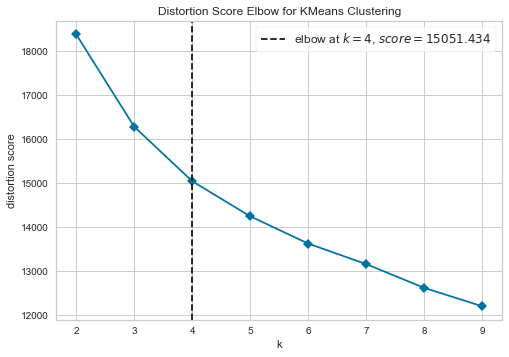

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [68]:
model = KMeans(init="k-means++", random_state=42, max_iter=10000)
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False)
visualizer.fit(scaled_data)
visualizer.show()

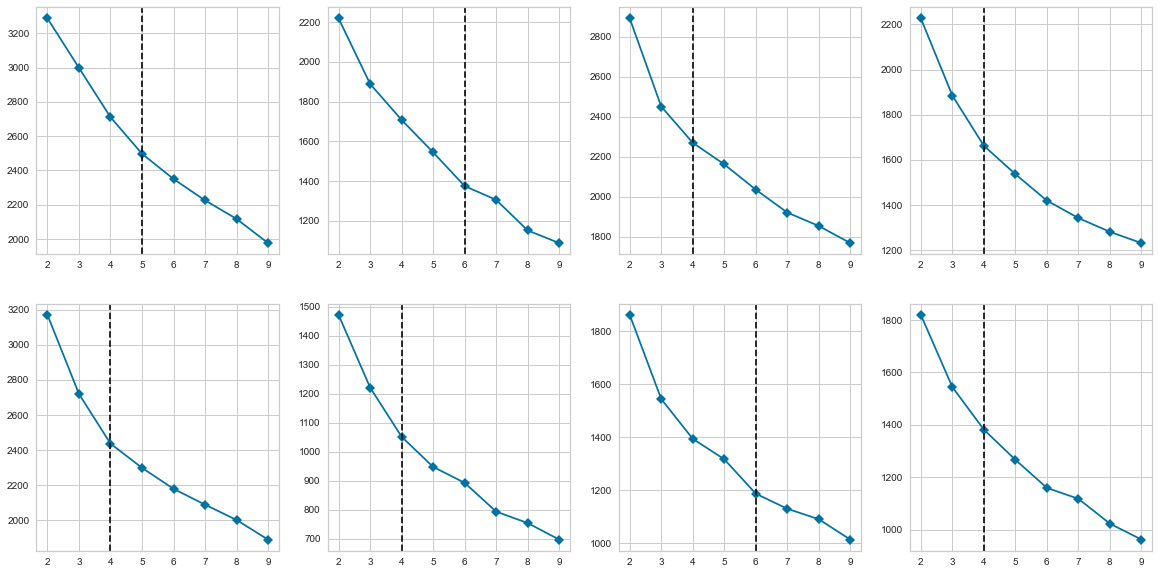

In [69]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,10))

for gen in range(1, 9):
    ax = axes.flat[gen-1]
    
    d1 = data[data['generation']==gen].drop(columns=['generation'])
    scaler = StandardScaler()
    scaler.fit(d1)
    d2 = pd.DataFrame(scaler.transform(d1), columns=d1.columns)

    model = KMeans(init="k-means++", random_state=42, max_iter=10000)
    visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False, ax=ax)
    visualizer.fit(d2)

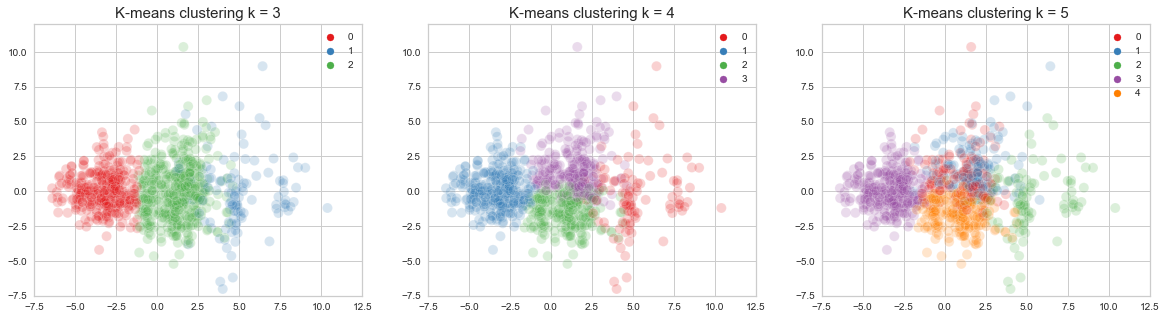

In [70]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,5))

for k in range(3, 6):
    ax = axes.flat[k-3]
    ax.set_xlim([-7.5, 12.5])
    ax.set_ylim([-7.5, 12])    
    kmeans = KMeans(init="k-means++", n_clusters=k, random_state=42, max_iter=10000).fit(scaled_data)
    d = PCA(n_components=2).fit_transform(scaled_data)
    sns.scatterplot(x=d[:,0], y=d[:,1], 
                hue=kmeans.labels_, 
                palette='Set1',
                s=100, alpha=0.2, ax=ax).set_title(f"K-means clustering k = {k}", fontsize=15)

with open('./map/pokemons.json', 'w') as f:
    f.write(pokemon[['number', 'name', 'image', 'generation']].to_json(orient="records"))
with open('./map/points.json', 'w') as f:
    json.dump(d.tolist(), f)

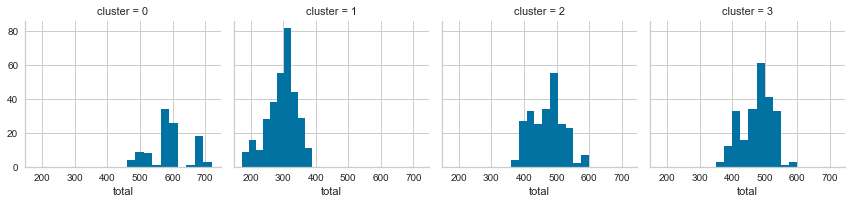

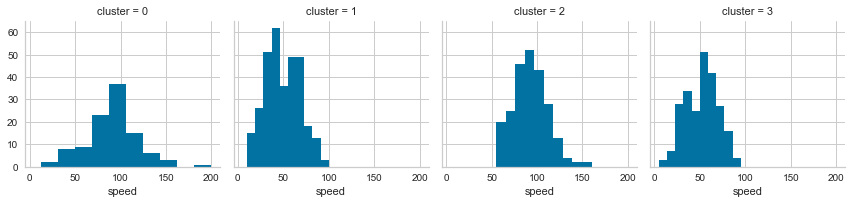

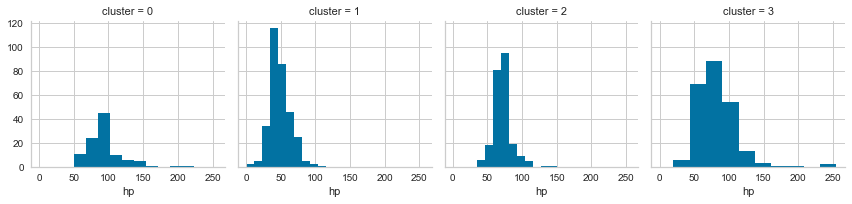

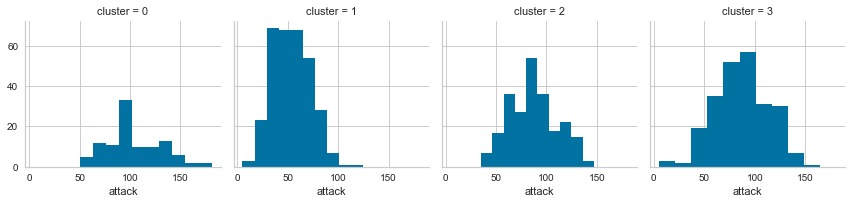

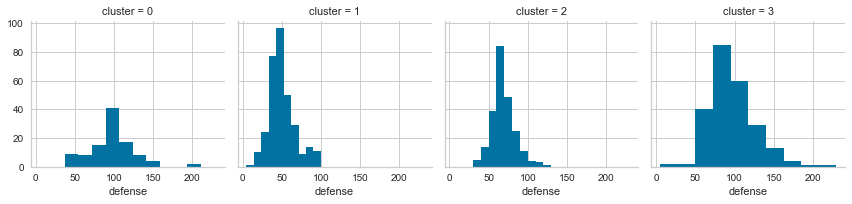

In [71]:
kmeans = KMeans(init="k-means++", n_clusters=4, random_state=42, max_iter=10000).fit(scaled_data)

d = pokemon.copy()
d['cluster'] = kmeans.labels_
for col in ['total', 'speed', 'hp', 'attack', 'defense']:
    g = sns.FacetGrid(d, col='cluster')
    g.map(plt.hist, col)

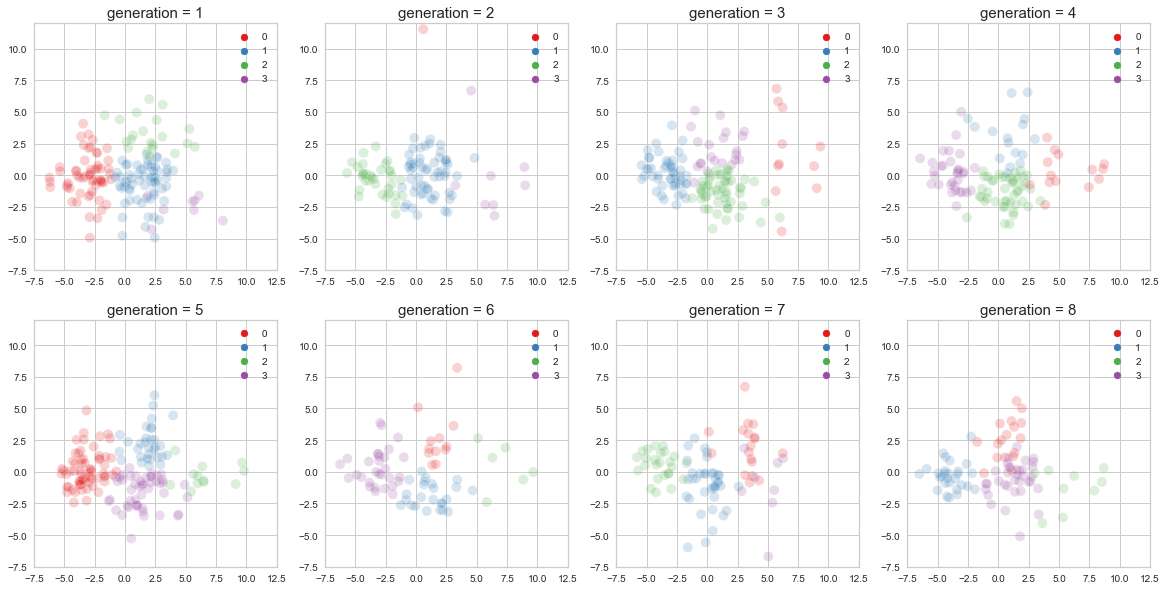

In [72]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20,10))

for gen in range(1, 9):
    ax = axes.flat[gen-1]
    ax.set_xlim([-7.5, 12.5])
    ax.set_ylim([-7.5, 12])
    
    d1 = data[data['generation']==gen].drop(columns=['generation'])
    scaler = StandardScaler()
    scaler.fit(d1)
    d2 = pd.DataFrame(scaler.transform(d1), columns=d1.columns)

    k = 4
    kmeans = KMeans(init="k-means++", n_clusters=k, random_state=42, max_iter=10000).fit(d2)
    d3 = PCA(n_components=2).fit_transform(d2)

    sns.scatterplot(x=d3[:,0], y=d3[:,1], 
                    hue=kmeans.labels_, 
                    palette='Set1',
                    s=100, alpha=0.2,ax=ax).set_title(f"generation = {gen}", fontsize=15)

In [75]:
d[d['cluster']==0]['is_legendary'].value_counts()

True     81
False    23
Name: is_legendary, dtype: int64

In [76]:
d['is_legendary'].value_counts()

False    806
True      92
Name: is_legendary, dtype: int64

In [77]:
d = data.drop(columns=['generation'])
scaler = StandardScaler()
scaler.fit(d)
X_scale = scaler.transform(d)
scaled_data = pd.DataFrame(X_scale, columns=d.columns)
scaled_data.head()

,type1,type2,height,weight,catch_rate,egg_group1,egg_group2,has_gender,male,hp,...,sp_atk,sp_atk_min,sp_atk_max,sp_def,sp_def_min,sp_def_max,speed,speed_min,speed_max,is_legendary
0,0.961974,1.491158,-0.393965,-0.475111,-0.689092,1.317721,1.961069,0.396505,1.492357,-0.917252,...,-0.159472,-0.159382,-0.161166,-0.181365,-0.181376,-0.183270,-0.736514,-0.736455,-0.738638,-0.337852
1,0.961974,1.491158,-0.150761,-0.425128,-0.689092,1.317721,1.961069,0.396505,1.492357,-0.344713,...,0.351492,0.351509,0.349636,0.372726,0.372693,0.370803,-0.209174,-0.209167,-0.211527,-0.337852
2,0.961974,1.491158,0.659918,0.287747,-0.689092,1.317721,1.961069,0.396505,1.492357,0.418671,...,1.032778,1.032696,1.030705,1.111514,1.111453,1.109567,0.493945,0.493884,0.491287,-0.337852
3,0.017666,-0.795428,-0.475032,-0.462001,-0.689092,-0.847537,1.961069,0.396505,1.492357,-1.146267,...,-0.329794,-0.329679,-0.331434,-0.735456,-0.735446,-0.737343,-0.033394,-0.033404,-0.035824,-0.337852
4,0.017666,-0.795428,-0.069693,-0.375964,-0.689092,-0.847537,1.961069,0.396505,1.492357,-0.421052,...,0.351492,0.351509,0.349636,-0.181365,-0.181376,-0.183270,0.493945,0.493884,0.491287,-0.337852


In [88]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = data.drop(columns=['is_legendary'])
y = data.is_legendary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
estimator = LogisticRegression(max_iter=4000)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print(estimator.score(X_train, y_train))

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

0.9836552748885586
Accuracy: 0.9688888888888889
Precision: 0.8095238095238095
Recall: 0.85


In [89]:
from sklearn.naive_bayes import GaussianNB

X = data.drop(columns=['is_legendary'])
y = data.is_legendary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
estimator = GaussianNB()
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print(estimator.score(X_train, y_train))

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

0.950965824665676
Accuracy: 0.9511111111111111
Precision: 0.68
Recall: 0.85


In [92]:
from sklearn.tree import DecisionTreeClassifier

X = data.drop(columns=['is_legendary'])
y = data.is_legendary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
estimator = DecisionTreeClassifier()
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print(estimator.score(X_train, y_train))

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

1.0
Accuracy: 0.96
Precision: 0.7619047619047619
Recall: 0.8


In [93]:
from sklearn.svm import SVC, LinearSVC


X = data.drop(columns=['is_legendary'])
y = data.is_legendary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
estimator = SVC()
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print(estimator.score(X_train, y_train))

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

0.9777117384843982
Accuracy: 0.9733333333333334
Precision: 0.9375
Recall: 0.75


In [85]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn import metrics

# X = d.drop(columns=['is_legendary'])
# y = d.is_legendary

# # 75% for training and 25% for model testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
# estimator = LogisticRegression(max_iter=10000)
# selector = RFECV(estimator, step=1, cv=5)
# selector = selector.fit(X, y)
# print(selector.support_)
# print(selector.ranking_)
# lr.fit(X_train,y_train)
# y_pred = lr.predict(X_test)
# print(lr.score(X_train, y_train))

# print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# print("Precision:", metrics.precision_score(y_test, y_pred))
# print("Recall:", metrics.recall_score(y_test, y_pred))

/Users/zuowang/.local/share/virtualenvs/pokemon-ml-nKW44vGo/lib/python3.9/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/Users/zuowang/.local/share/virtualenvs/pokemon-ml-nKW44vGo/lib/python3.9/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


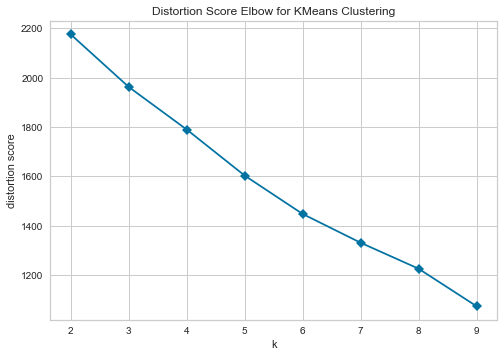

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [107]:
# d = data[data["is_legendary"]==1].drop(columns=['generation', 'is_legendary'])
# scaler = StandardScaler()
# scaler.fit(d)
# X_scale = scaler.transform(d)
# scaled_data = pd.DataFrame(X_scale, columns=d.columns)
# scaled_data.head()

# model = KMeans(init="k-means++", random_state=42, max_iter=20000)
# visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False)
# visualizer.fit(scaled_data)
# visualizer.show()
# kmeans = KMeans(init="k-means++", n_clusters=3, random_state=42, max_iter=10000).fit(scaled_data)
# d = PCA(n_components=3).fit_transform(scaled_data)
# sns.scatterplot(x=d[:,0], y=d[:,1], 
#             hue=kmeans.labels_, 
#             palette='Set1',
#             s=100, alpha=0.2).set_title(f"K-means clustering k = {k}", fontsize=15)